In [2]:
!pip install pymongo dnspython


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from pymongo import MongoClient
import pandas as pd

In [186]:
client = MongoClient('mongodb://localhost:27017/Car')

In [187]:
db = client['Car']

In [188]:
collection = db['Car Analysis']

In [189]:
collection

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'Car'), 'Car Analysis')

In [190]:
data = list(collection.find())

In [191]:
df = pd.DataFrame(data)

In [192]:
df.head()

,_id,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice
0,674efa8b9faadfc3a63e7c45,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,Nov-24,"Honda City v teck in mint condition, valid gen...","₹ 1,95,000"
1,674efa8b9faadfc3a63e7c46,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,Jul-24,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","₹ 3,75,000"
2,674efa8b9faadfc3a63e7c47,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,Nov-24,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","₹ 1,84,999"
3,674efa8b9faadfc3a63e7c48,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,Nov-24,Maruti Suzuki Swift 2017 Diesel Good Condition,"₹ 5,65,000"
4,674efa8b9faadfc3a63e7c49,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,Nov-24,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","₹ 6,85,000"


In [193]:
df.columns

Index(['_id', 'Brand', 'model', 'Year', 'Age', 'kmDriven', 'Transmission',
       'Owner', 'FuelType', 'PostedDate', 'AdditionInfo', 'AskPrice'],
      dtype='object')

In [194]:
df=df.drop("_id" ,axis=1)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Brand         9582 non-null   object
 1   model         9582 non-null   object
 2   Year          9582 non-null   int64 
 3   Age           9582 non-null   int64 
 4   kmDriven      9535 non-null   object
 5   Transmission  9582 non-null   object
 6   Owner         9582 non-null   object
 7   FuelType      9582 non-null   object
 8   PostedDate    9582 non-null   object
 9   AdditionInfo  9582 non-null   object
 10  AskPrice      9582 non-null   object
dtypes: int64(2), object(9)
memory usage: 823.6+ KB


In [196]:
df.isna().sum()

Brand            0
model            0
Year             0
Age              0
kmDriven        47
Transmission     0
Owner            0
FuelType         0
PostedDate       0
AdditionInfo     0
AskPrice         0
dtype: int64

In [197]:
df.shape

(9582, 11)

In [198]:
#We notice an Null values in KM Driven So that we can Handle it Later 

In [199]:
df['Brand'].mode()

0    Maruti Suzuki
Name: Brand, dtype: object

In [200]:
df['model'].mode()

0    City
Name: model, dtype: object

In [201]:
df.duplicated().sum()

724

In [202]:
# Remove duplicate rows, keeping only the first occurrence
df = df.drop_duplicates()


In [203]:
df.shape

(8858, 11)

In [204]:
df.describe()

,Year,Age
count,8858.000000,8858.000000
mean,2016.377060,7.622940
std,4.134203,4.134203
min,1986.000000,0.000000
25%,2014.000000,5.000000
50%,2017.000000,7.000000
75%,2019.000000,10.000000
max,2024.000000,38.000000


In [205]:
df.groupby('Owner').size()

Owner
first     4596
second    4262
dtype: int64

In [206]:
#Data Visualization

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

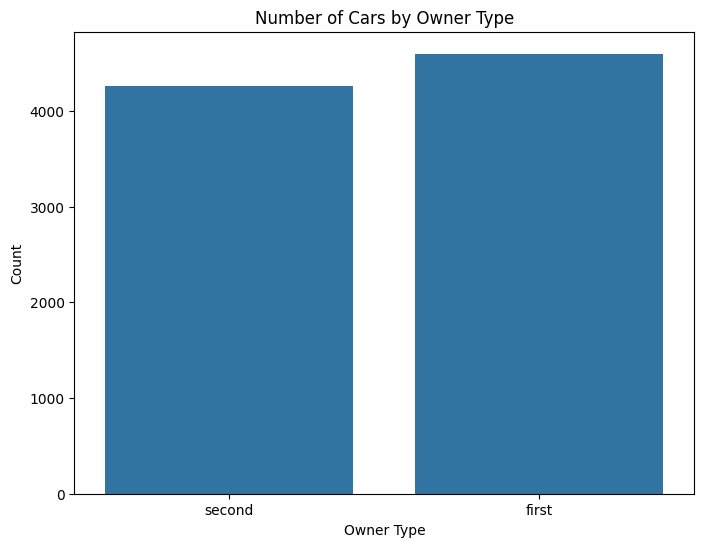

In [208]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Owner' )
plt.title('Number of Cars by Owner Type')
plt.xlabel('Owner Type')
plt.ylabel('Count')
plt.show()
# Convert 'AskPrice' to numeric (removing ₹ symbol and commas)
df['AskPrice'] = df['AskPrice'].replace({'₹': '', ',': ''}, regex=True).astype(float)


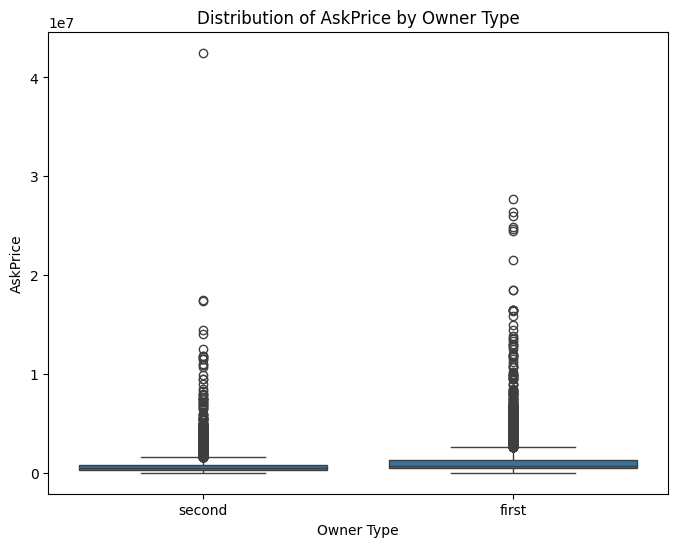

In [209]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Owner', y='AskPrice')
plt.title('Distribution of AskPrice by Owner Type')
plt.xlabel('Owner Type')
plt.ylabel('AskPrice')
plt.show()

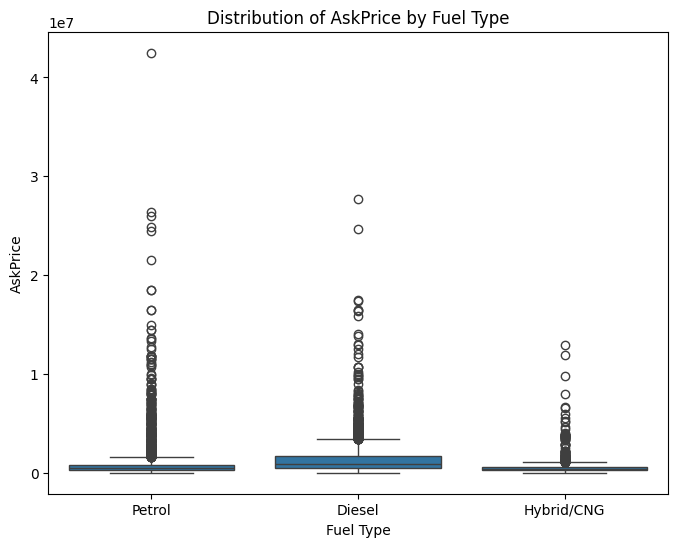

In [210]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='FuelType', y='AskPrice')
plt.title('Distribution of AskPrice by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('AskPrice')
plt.show()

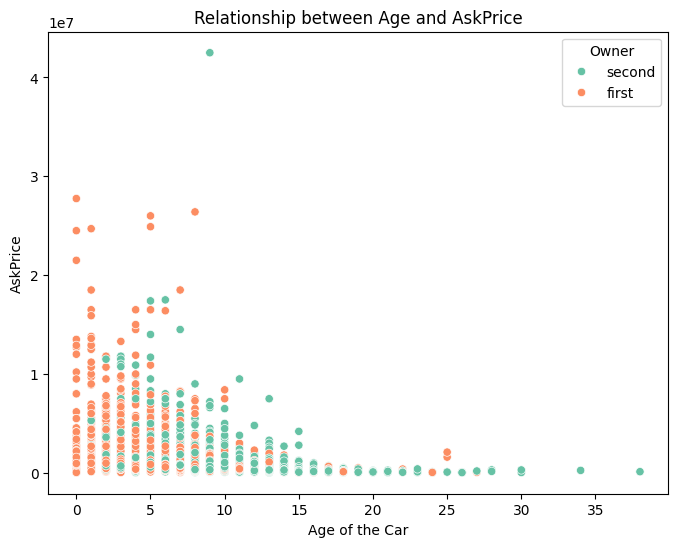

In [211]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='AskPrice', hue='Owner', palette='Set2')
plt.title('Relationship between Age and AskPrice')
plt.xlabel('Age of the Car')
plt.ylabel('AskPrice')
plt.show()

In [212]:
# Seemsto Be the most of the First hand cars to be sold within the 10 years and  2nd handed cars were mstly after 5 years

In [213]:
# Handling Outliers

In [214]:
df['AskPrice'] = df['AskPrice'].replace({'₹': '', ',': ''}, regex=True).astype(float)
df['kmDriven'] = df['kmDriven'].replace({' km': '', ',': ''}, regex=True).astype(float)

In [215]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [216]:
df = remove_outliers(df, 'AskPrice')
df = remove_outliers(df, 'kmDriven')
df = remove_outliers(df, 'Age')

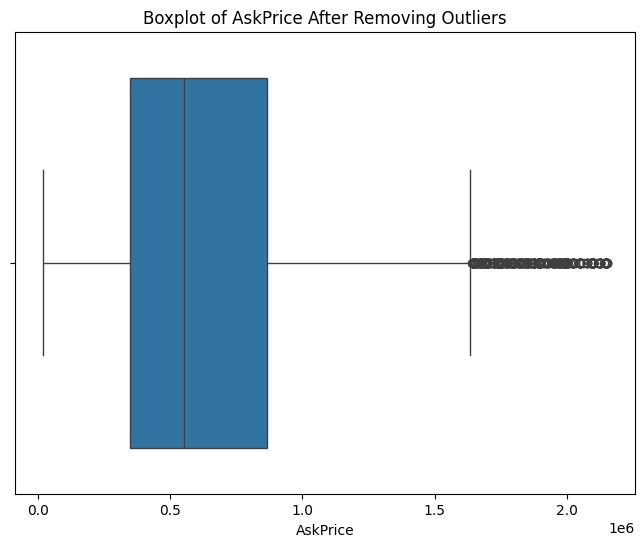

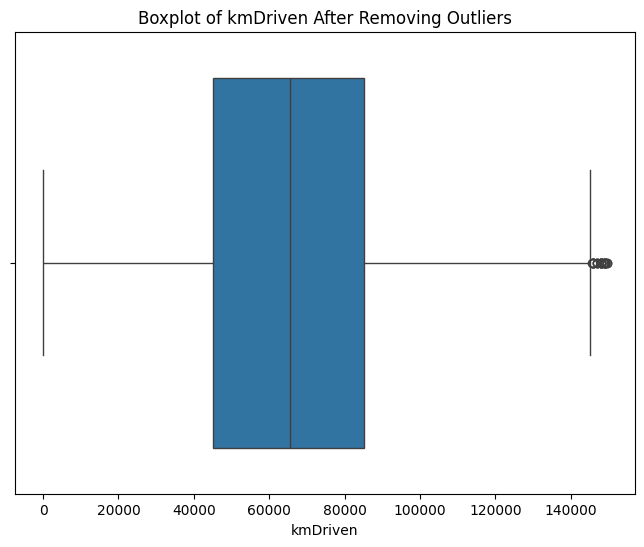

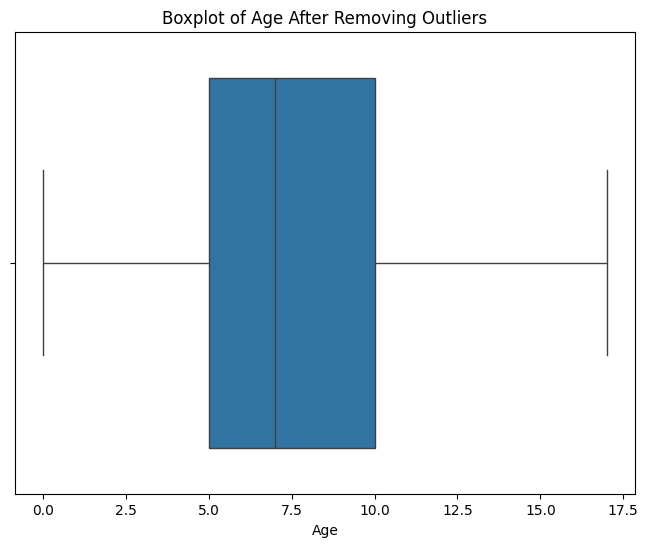

           AskPrice       kmDriven          Age
count  7.493000e+03    7493.000000  7493.000000
mean   6.745347e+05   65452.343921     7.612438
std    4.569118e+05   30416.188058     3.784902
min    1.850000e+04       0.000000     0.000000
25%    3.490000e+05   45000.000000     5.000000
50%    5.500000e+05   65374.000000     7.000000
75%    8.650000e+05   85000.000000    10.000000
max    2.151000e+06  149500.000000    17.000000


In [217]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['AskPrice'])
plt.title('Boxplot of AskPrice After Removing Outliers')
plt.show()

# Boxplot for kmDriven after removing outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['kmDriven'])
plt.title('Boxplot of kmDriven After Removing Outliers')
plt.show()

# Boxplot for Age after removing outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Age'])
plt.title('Boxplot of Age After Removing Outliers')
plt.show()

# Verify the remaining outliers using summary statistics
print(df[['AskPrice', 'kmDriven', 'Age']].describe())

In [218]:
#Model 

In [219]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [134]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [220]:
df = pd.get_dummies(df, columns=['Brand', 'model'], drop_first=True)
df = pd.get_dummies(df, columns=['Owner', 'FuelType'], drop_first=True)

In [222]:
X = df[['Age', 'kmDriven', 'Owner_second', 'FuelType_Petrol']]

# Target variable (dependent variable)
y = df['AskPrice']


In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [224]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [225]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [226]:
y_pred = model.predict(X_test_scaled)

In [227]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [228]:
sample_data = pd.DataFrame({
    'Age': [0],
    'kmDriven': [0],
    'Owner_second': [0],
    'FuelType_Petrol': [0]
})


In [229]:
sample_data_scaled = scaler.transform(sample_data)
predicted_price = model.predict(sample_data_scaled)
print(f"Predicted AskPrice for the sample data: ₹ {predicted_price[0]:,.2f}")

Predicted AskPrice for the sample data: ₹ 1,189,523.58
